[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

## Instructions
To run any of Eden's notebooks, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will try to reply as soon as possible.

## Background (Go to [Bibliography](#references) for more)

In the agriculture, for the problem of **data scarcity**, several techniques have been used by researchers to create more images based on the available datasets. The one which is shown in this notebook is data augmentation by performing different geometric and colour transformations into the images (**Dyrmann et al., 2016; Mehdipour-Ghazi et al., 2017; Fuentes et al., 2017; **). Data augmentation is not only useful for improving the performance of the deep neural network, but also for reducing <a href="https://en.wikipedia.org/wiki/Overfitting">overfitting</a>.

<a href="https://albumentations.ai/">Albumentations</a> is a Python library for creating different image augmentation pipelines. It implements a rich variety of image transform operations for different computer vision tasks, including object classification, segmentation, and detection. In this notebook, we are going to focus on augmentations based on weather conditions, which are very important to model while working on precision agriculure.

In [1]:
!pip install -q -U albumentations
!echo "$(pip freeze| grep albumentations) is succesfully installed"

albumentations==1.1.0 is succesfully installed


In [17]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import *
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split

import matplotlib.cm as cm
from numpy import expand_dims

from functools import partial
from albumentations import (
    Compose,
    HorizontalFlip,
    Rotate,
    RandomRain,
    RandomFog,
    RandomSnow,
)

#### Auxiliar Functions

In [18]:
class EnoughPerformanceReached(Callback):
    """
    Callback for stopping training when the performance is greater than <threshold>.
    """

    def __init__(self, threshold):
        self.monitor = "val_acc"
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs):
        current_accuracy = logs.get(self.monitor)
        if current_accuracy >= self.threshold:
            print(f"[INFO] Enough performance reached: {current_accuracy}")
            self.model.stop_training = True


# Function for plotting images.
def plot_samples(sample_images):

    PLOT_NUM_ROWS = 3
    PLOT_NUM_COLS = 3
    plt.figure(figsize=(PLOT_NUM_ROWS * 1.5, PLOT_NUM_COLS * 1.5), dpi=100)
    for ix, sample_image in enumerate(sample_images[:9]):
        plt.subplot(PLOT_NUM_ROWS, PLOT_NUM_COLS, ix + 1)
        plt.imshow(sample_image.numpy().astype(np.uint8))
        plt.axis("off")
    plt.show()


def read_data(path_list, im_size=224):
    """
    Given the list of paths where the images are stored <path_list>,
    and the size for image decimation <im_size>, it returns 2 Numpy Arrays
    with the images and labels; and a dictionary with the mapping between
    classes and folders. This will be used later for displaying the predicted
    labels.

        Parameters:
            path_list (List[String]): The list of paths to the images.
            im_size (Tuple): The height and width values.

        Returns:
            X (ndarray): Images
            y (ndarray): Labels
            tag2idx (dict): Map between labels and folders.
    """

    X = []
    y = []

    # Exctract the file-names of the datasets we read and create a label dictionary.
    tag2idx = {tag.split(os.path.sep)[-1]: i for i, tag in enumerate(path_list)}

    for path in path_list:
        for im_file in tqdm(glob(path + "*/*")):  # Read all files in path
            try:
                # os.path.separator is OS agnostic (either '/' or '\'),[-2] to grab folder name.
                label = im_file.split(os.path.sep)[-2]
                im = cv2.imread(im_file, cv2.IMREAD_COLOR)
                # By default OpenCV read with BGR format, return back to RGB.
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                # Resize to appropriate dimensions.You can try different interpolation methods.
                im = cv2.resize(im, (im_size, im_size), interpolation=cv2.INTER_AREA)
                X.append(im)
                y.append(tag2idx[label])  # Append the label name to y
            except Exception as e:
                # In case annotations or metadata are found
                print(e)
                # print("Not a picture")

    X = np.array(X)  # Convert list to numpy array.
    y = np.eye(len(np.unique(y)))[y].astype(np.uint8)
    idx2tag = {v: k for k, v in tag2idx.items()}

    return X, y  # , idx2tag


# Callbacks are used for saving the best weights and
# early stopping.
def get_callbacks(patience):
    """
    Callbacks are used for saving the best weights and early stopping.
    Given some configuration parameters, it creates the callbacks that
    will be used by Keras after each epoch.

        Parameters:
            patience (Integer): Number of epochs without improvement to wait.

        Returns:
            callbacks (List[Callbacks]): Configured callbacks ready to use.
    """
    return [
        # If val_loss doesn't improve for a number of epochs set with 'patience' var
        # training will stop to avoid overfitting.
        EarlyStopping(
            monitor="val_acc",
            mode="max",
            patience=patience,
            restore_best_weights=True,
            verbose=1,
        ),
        # EnoughPerformanceReached(0.99)
    ]

In [23]:
def get_model():
    base_model = keras.applications.ResNet50V2(include_top=False,
                                               weights="imagenet",
                                               input_shape=(IM_SIZE, IM_SIZE, 3))
    preprocess_input = applications.resnet_v2.preprocess_input
    
    base_model.trainable = True

    inputs = layers.Input(shape=(IM_SIZE, IM_SIZE, 3))
    preprocessed_inputs = layers.Lambda(preprocess_input)(inputs)
    features = base_model(preprocessed_inputs, training=True)
    features = layers.Conv2D(32, (1, 1), activation="relu")(features)
    features = layers.Dropout(0.5)(features)
    features = layers.Flatten()(features)
    x = layers.Dense(HIDDEN_UNITS, activation="relu")(features)
    out = layers.Dense(2, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=out)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=BASE_LEARNING_RATE),
                  loss=keras.losses.CategoricalCrossentropy(),
                  metrics=[keras.metrics.CategoricalAccuracy(name="acc")])
    
    return model

#### Albumentations auxiliar functions

In [20]:
def aug_fn(image, img_size):
    transforms = Compose(
        [
            HorizontalFlip(),
            RandomRain(brightness_coefficient=0.9, drop_width=3, blur_value=5, p=0.5),
            RandomFog(fog_coef_lower=0.65, fog_coef_upper=0.75, alpha_coef=0.2, p=0.5),
            RandomSnow(
                brightness_coeff=1.25,
                snow_point_lower=0.1,
                snow_point_upper=0.25,
                p=0.5,
            ),
        ]
    )

    data = {"image": image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    # aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    return aug_img


def process_data(image, label, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img, label

#### Experimental Constants

In [27]:
IM_SIZE = 224
NUM_CLASSES = 4
NUM_EPOCHS = 20
BATCH_SIZE = 16
TEST_SPLIT = 0.15
VAL_SPLIT = 0.15
BASE_LEARNING_RATE = 1e-3
RANDOM_STATE = 2021
HIDDEN_UNITS = 64
WEIGHTS_FILE_NAME = "weights.h5"  # File that stores updated weights
VERBOSE_LEVEL = 1
AUTO = tf.data.AUTOTUNE
BASE_PATH = "eden_library_datasets" + os.path.sep

PATH_LIST = [
    BASE_PATH + "Tomato-211120-Healthy-zz-V1-20210225103833",
    BASE_PATH + "Zucchini-211120-Healthy-zz-V1-20210225104250",
]

tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

#### Loading images as numpy arrays

In [22]:
i = 0
for path in PATH_LIST:
    # Define paths in an OS agnostic way.
    PATH_LIST[i] = str(Path(Path.cwd()).parents[0].joinpath(path))
    i += 1
x, y = read_data(PATH_LIST, IM_SIZE)

100%|██████████| 70/70 [00:35<00:00,  1.96it/s]


#### Splitting the data for training and evaluation

In [24]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=TEST_SPLIT, shuffle=True, stratify=y, random_state=RANDOM_STATE
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train,
    y_train,
    test_size=VAL_SPLIT,
    shuffle=True,
    stratify=y_train,
    random_state=RANDOM_STATE,
)

#### Creating Tensorflow datasets from Numpy Arrays

In [25]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

#### Creating Augmentation Pipelines

In [28]:
clean_train_ds = train_data.shuffle(BATCH_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

clean_validation_ds = validation_data.batch(BATCH_SIZE).prefetch(AUTO)

clean_test_ds = test_data.batch(BATCH_SIZE).prefetch(AUTO)

noisy_train_ds = (
    train_data.shuffle(BATCH_SIZE)
    .map(partial(process_data, img_size=IM_SIZE), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

noisy_test_ds = (
    test_data.map(partial(process_data, img_size=IM_SIZE), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

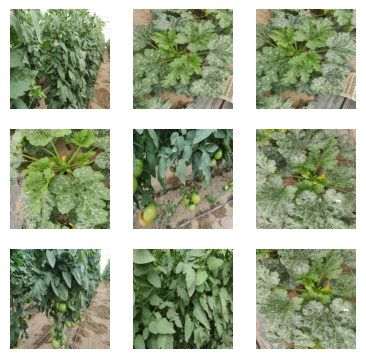

In [29]:
sample_images, sample_labels = next(iter(clean_train_ds))
plot_samples(sample_images)

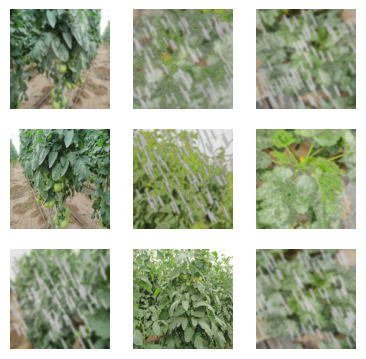

In [30]:
sample_images, sample_labels = next(iter(noisy_train_ds))
plot_samples(sample_images)

In [31]:
model = get_model()
model.save_weights("initial_weights.h5")

clean_history = model.fit(
    clean_train_ds,
    validation_data=clean_validation_ds,
    callbacks=get_callbacks(patience=NUM_EPOCHS // 5),
    epochs=NUM_EPOCHS,
)

Epoch 1/20
8/8 [==============================] - 7s 244ms/step - loss: 0.5658 - acc: 0.7434 - val_loss: 0.0575 - val_acc: 1.0000
Epoch 2/20
8/8 [==============================] - 0s 50ms/step - loss: 0.1925 - acc: 0.9204 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 3/20
8/8 [==============================] - 0s 48ms/step - loss: 0.1111 - acc: 0.9469 - val_loss: 0.0681 - val_acc: 0.9524
Epoch 4/20
8/8 [==============================] - 0s 50ms/step - loss: 0.2438 - acc: 0.9381 - val_loss: 0.0133 - val_acc: 1.0000
Epoch 5/20
8/8 [==============================] - 0s 49ms/step - loss: 0.1258 - acc: 0.9912 - val_loss: 0.0123 - val_acc: 1.0000
Restoring model weights from the end of the best epoch.
Epoch 00005: early stopping


In [32]:
_, test_acc = model.evaluate(clean_test_ds, verbose=0)
print(f"Clean Test Accuracy: {round(test_acc*100,2)}%")

_, test_acc = model.evaluate(noisy_test_ds, verbose=0)
print(f"Noisy Test Accuracy: {round(test_acc*100,2)}%")

Clean Test Accuracy: 100.0%
Noisy Test Accuracy: 91.67%


In [33]:
model.load_weights("initial_weights.h5")
noisy_history = model.fit(
    noisy_train_ds,
    validation_data=clean_validation_ds,
    callbacks=get_callbacks(patience=NUM_EPOCHS // 5),
    epochs=NUM_EPOCHS,
)

Epoch 1/20
8/8 [==============================] - 3s 54ms/step - loss: 0.8611 - acc: 0.5841 - val_loss: 0.4456 - val_acc: 0.8571
Epoch 2/20
8/8 [==============================] - 1s 51ms/step - loss: 0.5724 - acc: 0.7699 - val_loss: 0.1542 - val_acc: 0.9524
Epoch 3/20
8/8 [==============================] - 1s 56ms/step - loss: 0.3261 - acc: 0.8407 - val_loss: 0.0502 - val_acc: 1.0000
Epoch 4/20
8/8 [==============================] - 1s 57ms/step - loss: 0.0980 - acc: 0.9469 - val_loss: 0.0337 - val_acc: 1.0000
Epoch 5/20
8/8 [==============================] - 1s 56ms/step - loss: 0.1513 - acc: 0.9646 - val_loss: 0.0446 - val_acc: 0.9524
Epoch 6/20
8/8 [==============================] - 1s 55ms/step - loss: 0.6218 - acc: 0.8496 - val_loss: 0.3135 - val_acc: 0.9048
Epoch 7/20
8/8 [==============================] - 1s 58ms/step - loss: 0.3890 - acc: 0.8584 - val_loss: 0.2683 - val_acc: 0.9048
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping


In [34]:
_, test_acc = model.evaluate(clean_test_ds, verbose=0)
print(f"Clean Test Accuracy: {round(test_acc*100,2)}%")

_, test_acc = model.evaluate(noisy_test_ds, verbose=0)
print(f"Noisy Test Accuracy: {round(test_acc*100,2)}%")

Clean Test Accuracy: 95.83%
Noisy Test Accuracy: 100.0%


## Possible Extensions
1. Try other augmentations or change the parameters in the used ones.
2. Use a different pre-trained network.
3. Try a different training approach where pre-trained weights are not loaded.
4. Try different epochs and batch sizes.

## Bibliography
<a id='references'></a>
Binguitcha-Fare, A., & Sharma, P. (2019). Crops and weeds classification using Convolutional Neural Networks via optimization of transfer learning parameters.

Dyrmann, M., Karstoft, H., & Midtiby, H.S. (2016). Plant species classification using deep convolutional neural networks. Biosystems Engineering, 151, 72-80.

Mehdipour-Ghazi, M., Yanikoglu, B.A., & Aptoula, E. (2017). Plant identification using deep neural networks via optimization of transfer learning parameters. Neurocomputing, 235, 228-235.

Fuentes, A., Yoon, S., Kim, S., & Park, D. (2017). A Robust Deep-Learning-Based Detector for Real-Time Tomato Plant Diseases and Pests Recognition. Sensors (Basel, Switzerland), 17.

https://albumentations.ai/docs/